In [2]:
import torch

# COVID-19 CT Images Segmentation

This solution is based on [this notebook](https://www.kaggle.com/code/maedemaftouni/pytorch-baseline-for-semantic-segmentation) by Maede Maftouni.

Team Alfa Buena Maravilla Onda Dinamita Escuadrón Lobo (5):
* A01027715 - Ulises Orlando Carrizalez Lerin
* A01028008 - Tomás Pérez Vera
* A01799609 - Bárbara Paola Alcántara Vega
* A01710965 - Mónica Monserrat Martínez Vásquez
* A01705840 - María José Soto Castro

# **Introduction**

The following notebook addresses a critical problem in medical image segmentation, specifically related to COVID-19 diagnosis and detection.

The objetive is to identify and mark specific lung areas in computed tomography (CT) scans by focusing on detecting key pulmonary features, such as ground glass opacities and consolidations, which are essential indicators of COVID-19 infection. 

Accurate segmentation of these areas is crucial for medical diagnosis, as it helps assess the severity of infection and provides valuable information for disease monitoring and treatment.

**The Challenge:**

Coronavirosis of 2019 (COVID-19) primarily affects the lower respiratory tract, which consists of the portion of the larynx below the vocal folds, the trachea, bronchi, bronchioles, and the lungs, which contain alveoli where gas exchange occurs (Content - Health Encyclopedia - University of Rochester Medical Center, 2025), this is why CT scans are great for detecting viral infections, as CT can distinguish between air, fluid, and soft tissue much more clearly, showing images that help detect abscesses, or fluid buildup in the lungs and pleura.

CT images are used by doctors for diagnosing the severity of the infection and monitoring disease progression, so accurately segmenting these regions aids in providing visual evidence of affected lung regions, improving clinical diagnosis, and supporting medical treatment decisions. 

**Kaggle Competition Objectives:**

The Kaggle competition's objective is to develop robust deep learning models capable of accurately segmenting lung regions affected by COVID-19 in CT scans. 

This is significant in the medical field, as it enhances (not replaces) diagnostic tools and allows healthcare professionals to track disease progression with ease by evaluating the provided precise visual information.

The notebook uses popular segmentation models based on architectures like U-Net and FPN (Feature Pyramid Network), which are widely used in medical imaging tasks due to their ability to capture both fine and global contextual information. Additionally, the following notebook also makes use of the segmentation_models_pytorch library, which simplifies model building and training by providing pre-trained segmentation backbones.

# **Data Analysis**

**Exploratory Data Analysis (EDA)**

The dataset provided in this competition includes lung CT scan images (with varying pixel dimentions) with their corresponding segmentation masks. The CT images come from two datasets:

* **Medseg Dataset:** 100 CT images from over 10 patients and their corresponding segmentation masks contain four channels:
  
   * Ground glass opacities
   * Consolidations
   * Unaffected lung tissue 
   * Background


* **Radiopaedia Dataset:** 829 CT slices with the structure of the images (520 x 520 pixels) and masks being similar to the Medseg dataset.

The segmentation masks label regions of interest in the lungs, including infected areas (ground glass and consolidation) and "normal" lung tissue. 

Visualizing these images helps doctors understand the data distribution and the extent of the infection in the lungs as the ifected to the normal areas ratio changes.

**Data Preprocessing**

Before training the model, the following data preprocessing steps must be made in order to make a robust model that can handle variations in the input data:

* **Resizing:** All images need to be resized to 520 x 520 pixels to ensure consistency in input dimensions.
* **Normalization:** Normalization of pixel values to a standard range, improving model convergence during training.
* **Data Augmentation:** Techniques such as random rotations, flips, and intensity shifts to increase the dataset's variability. (helping the model generalize better to unseen data.)


# **Model**

**Model Architecture**

The U-Net architecture is an optimal choice for the challenge of identifying intricate lung structures. This architecture is a popular choice for medical image segmentation due to its symmetrical design and skip connections that retain spatial information, making it well-suited for detecting infected and healthy areas of the lungs because of its ability to accurately segment complex shapes in medical images. 

A great characteristic of the U-Net architecture is the use of skip connections that ensure that the model does not lose important spatial information during downsampling. 

The architecture consists of:

* **Encoder:** Series of convolutional layers followed by max-pooling layers to downsample the input image and extract features.
* **Decoder:** Upsampling layers that reconstruct the image to its original resolution while merging feature maps from the encoder via skip connections to retain fine details.
* **Skip Connections:** Which allow the model to merge high-level features with low-level spatial information, and therefore improving segmentation accuracy for small details.

Adittional important information:

* **Kernel Size:** The convolutional layers use a standard kernel size of 3x3, with stride 1 and appropriate padding to maintain spatial dimensions.
* **Max Pooling:** Reduces the spatial dimensions of the feature maps while retaining the most important features.
* **Activation Functions:** The model uses ReLU for non-linearity in the convolutional layers and Sigmoid in the output layer for binary segmentation.
* **Cross-Entropy Loss:**
The cross-entropy loss function measures the difference between the predicted segmentation mask and the ground truth mask by penalizing incorrect classifications for each pixel. It is very effective in dealing with multiple classes and imbalanced datasets.

Cross entropy is defined by the following equation:

$$
\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \log(p_i)
$$

Where:

  * 𝑦 is the true label for pixel 𝑖
  * 𝑝 is the predicted probability for that label.





**References**


Content - Health Encyclopedia - University of Rochester Medical Center. (2025). https://www.urmc.rochester.edu/encyclopedia/content?contentid=p01300&contenttypeid=85.

Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. International Conference on Medical Image Computing and Computer-Assisted Intervention (MICCAI).

# But what about the ethical implications of using these images for developing a diagnosis tool?
The analyzed images were originally obtained from SIRM (Società Italiana di Radiologia Medica e Interventistica), which follows a series of regulations to protect individuals' information and allow its use for academic or scientific purposes. Among these regulations, we can find:

* **D. Lgs. 101/2018:** Implements the General Data Protection Regulation (GDPR) in Italy. This is crucial as it sets the rules for processing personal data, including medical images that may contain sensitive information. In this specific case, the following measures must be followed:
* Anonymization of the images to ensure that patients cannot be identified.
* Explicit consent from patients to use their images.

* **Legge 219/2017:** This law establishes the rules for informed consent and advance treatment directives.

* **Legge 3/2018:** Covers aspects of clinical experimentation and the reorganization of healthcare professions.

Therefore, making the images safe to use as pesonal data is protected and consented to be worked with as long as they're annonimized.

However, it's important to mention that AI tools should not be used for detecting and diagnosing as a whole, and a medical profecional must monitor every aspect of the clinical case as they're using the provided tools. The segmentation does not serve as a replacement for specialists, but as an enhancement of medical tools (Farhud & Zokaei, 2021).

References

Società Italiana di Radiologia Medica e Interventistica (2024). Archivio Documenti. Normativa. https://sirm.org/documenti/

Farhud, D. D., & Zokaei, S. (2021). Ethical issues of artificial intelligence in medicine and healthcare. Iranian Journal of Public Health. https://doi.org/10.18502/ijph.v50i11.7600

# Imported modules:

In [3]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.2 MB/s eta 0:00:0000:0100:01m
  Attempting uninst

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-segmentation/masks_medseg.npy
/kaggle/input/covid-segmentation/images_medseg.npy
/kaggle/input/covid-segmentation/test_images_medseg.npy
/kaggle/input/covid-segmentation/masks_radiopedia.npy
/kaggle/input/covid-segmentation/images_radiopedia.npy


# Data description

The data used for training comes from Medseg and Radiopedia data sets. 

All images and masks have a size of 520 x 520 but are stanmdardized either way in case new data comes in another dimentions. 

Examples of the images are provided in the **Extraction** section.


* **The Medseg set:** 100 CT images and 100 masks from more than 40 patients. The set contains 

The 100 masks have four channels: 

(0 - "ground glass",

1 - "consolidations",

2 - "lungs other",

3 - "background" ). 

--> The test set is also taken from this set, and it consists of 10 images. <--


* **The Radiopedia set:** Same structure of the images and masks as the first data set. It contains 829 slices from segmented axial volumetric CTs.

  Images from radiopedia are full CT volumes:

Class 0 is "ground glass"

Class 1 is "consolidations"

Class 2 is "lungs other" – it doesn't mean that it is healthy lungs (not needed for analysis)

Class 3 is "background" – not lungs (not needed for analysis)

# Data extraction:

The data (images) is extracted from the given repositories and are stored in numpy arrays. The images are already formatted and have their masks assigned as labels.

In [5]:
prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

A function for visalization is defined and then the code prints a matrix with the original images in a grey scale in the superior row. 

The masks are shown in the correspondent column.

The masks that are going to be predicted with the model are ground glass and consolidation (the second and third rows respectively).

In [6]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode: 
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else: 
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

### Images from radiopedia are full CT volumes:
Class 0 is "ground glass"<br>
Class 1 is "consolidations"<br>
Class 2 is "lungs other" – it doesn't mean that it is healthy lungs (you don't need to predict this class)<br>
Class 3 is "background" – not lungs (you don't need to predict this class)<br>

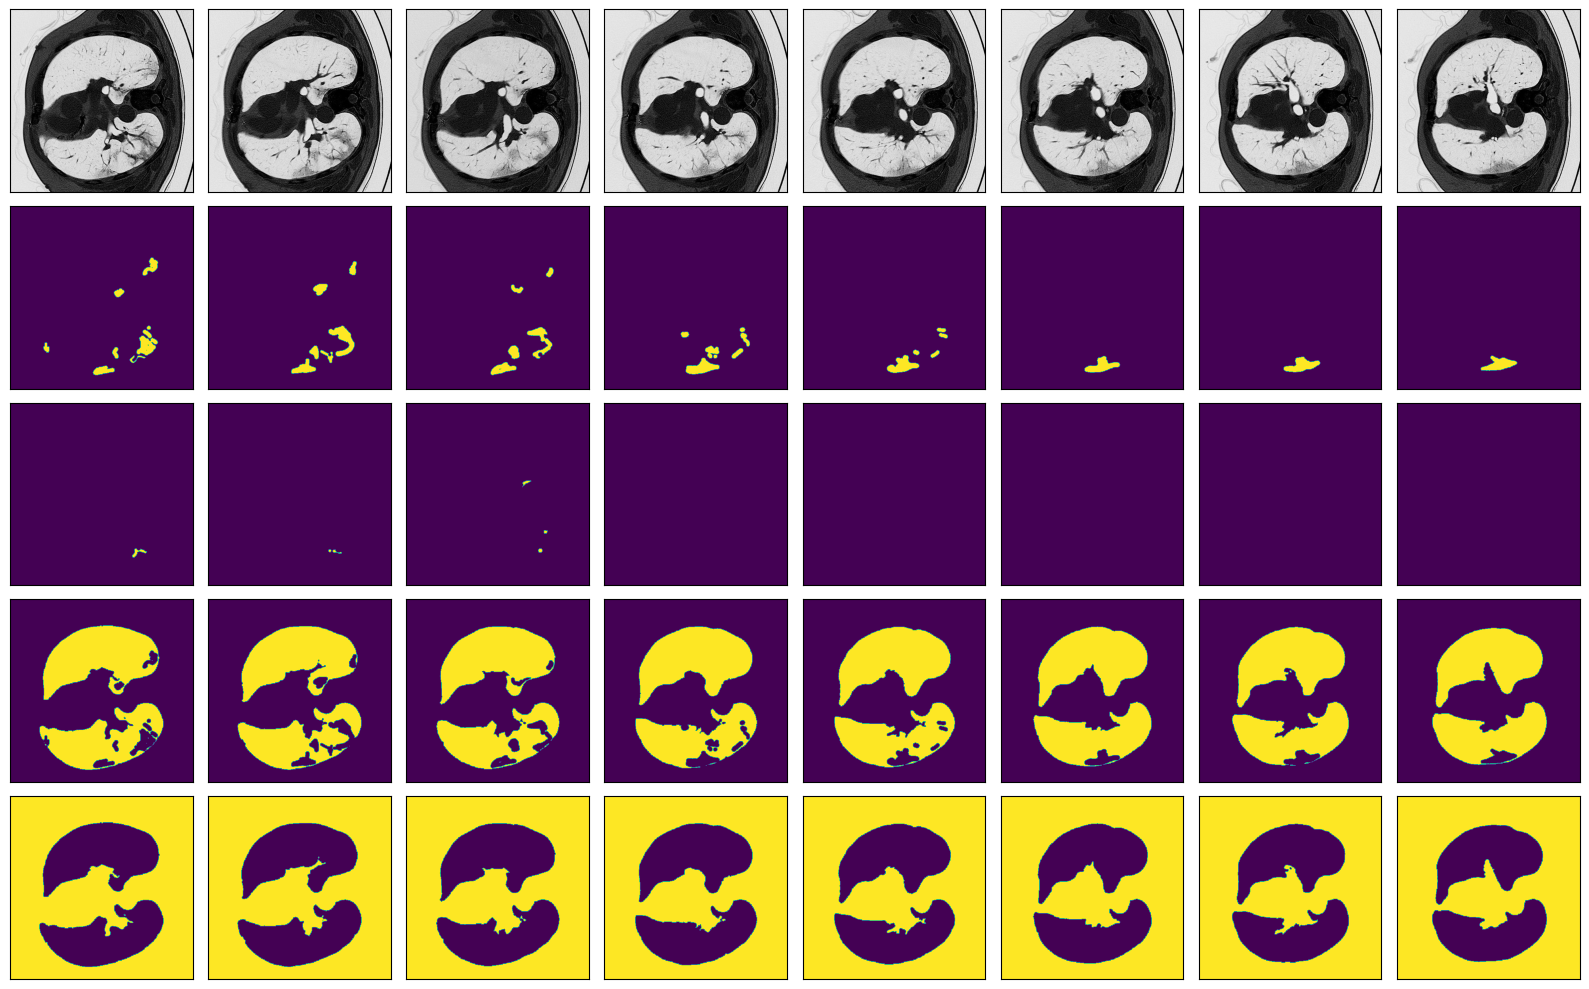

In [7]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

Both of the classes that we want to predict are pretty small compared to the complete image, so we have an important class imbalance.

To fix this, we define a function to convert the one hot encoded mask to a segmentation mask:

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


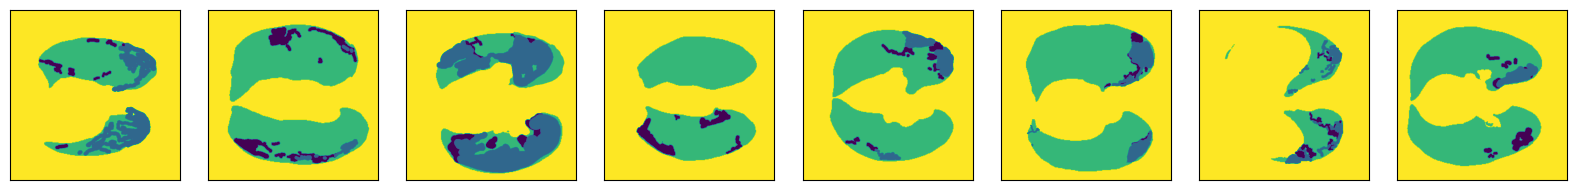

In [8]:
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

palette = [[0], [1], [2],[3]]
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)

masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

print('Hot encoded mask size: ',masks_radiopedia.shape)
print('Paletted mask size:',masks_medseg_recover.shape)

visualize(masks_medseg_recover[30:],hot_encode=False)

### Preprocessing the images:

In [9]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.64862060546875, std 458.5678405761719
mean -451.64862060546875, std 458.5678405761719
mean -451.64862060546875, std 458.5678405761719


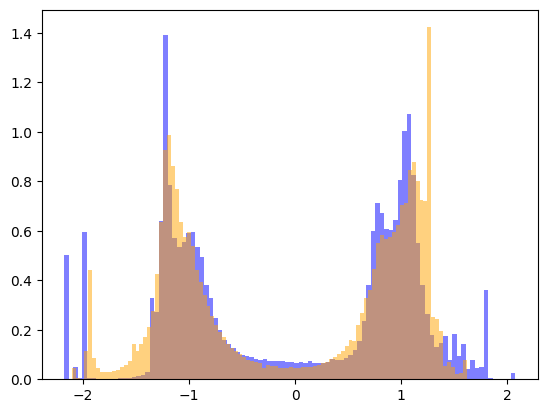

In [10]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show();
    
plot_hists(test_images_medseg, images_radiopedia)

## Split train / val:

Then we need to separate the image sets into validation and train.

The test set is already provided by the competition, but for validation, 24 images were selected from the medseg.

The rest of medseg and all of the images from radiopedia were selected for training, with a size of ~800.

In [11]:
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)


val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

batch_size = len(val_masks)

del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

## Data generator and augmentations:

The training data set is relatively small, with less than 1000 images. So the library Albumentations to improve the variety of the set by applying random transformations to the images. This reduces overfitting and increases the accuracy of the model. 

This works because it can apply the same transformation to an image and its corresponding mask. 

The transformations applied are the following:
* **Rotation:** With a limit of 360 degrees, with a probability of 90%, which means that the images can be completely rotated with a great chance of ending in different positions.
* **Random sized crop:** Crops a portion of each image with a limit of 75% of the original size, and rescales the cropped image to the original size.
* **Horizontal flip:** Flipping the image with a probability of 50%.

In [12]:
#import tensorflow

import albumentations

import cv2

SOURCE_SIZE = 512
TARGET_SIZE = 256


train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   (TARGET_SIZE, TARGET_SIZE), 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

# Loading:

A dataset object is defined with three methods besides its constructor:

* **\_\_getitem\_\_** Which returns an item from the dataset after transforming the image to a tensor. (It also applies the tranformation defined previously.)
* **\_\_len\_\_** Which returns the length of the dataset.
* And **tiles** Which returns a two tensors containing an image an its mask, where each item is a patch of the original image.

In [13]:
from PIL import Image
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import time

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader  
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']
        
        if self.augmentations is None:
            image = Image.fromarray(image)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
    
        return image, mask
    
    def __len__(self):
        return len(self.images)
    
    def tiles(self, image, mask):

        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    
                
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)       

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model:

Helper functions are defined for visualization and analysis:

## mask_to_onehot

Converting a segmentation mask into a one-hot encoded representation, which is a binary representation where a class is represented with a vector that has a value of 1 at the position corresponding to that class, and 0 at all other positions. 

The steps are enlisted below:

1.  An empty list called semantic_map is created that will serve to store the class maps for each color in the palette.
2.  For each color in the palette the mask is compared to the color using. This generates a Boolean matrix indicating where in the image pixels match that color. Then, it is checked if all the color channels match, generating a binary map (H, W) where True indicates that that pixel belongs to the class corresponding to the color of the palette.
This class map is added to the semantic_map list.
3.  The class maps for each color are stacked along a new dimension. This converts semantic_map to a matrix of dimensions (H, W, K), where K is the number of classes. Finally, the result is converted to a float tensor and then to a PyTorch tensor.
4.  The function returns a one-hot encoding tensor of dimensions (H, W, K), where each pixel is represented by a one-hot vector indicating which class it belongs to.

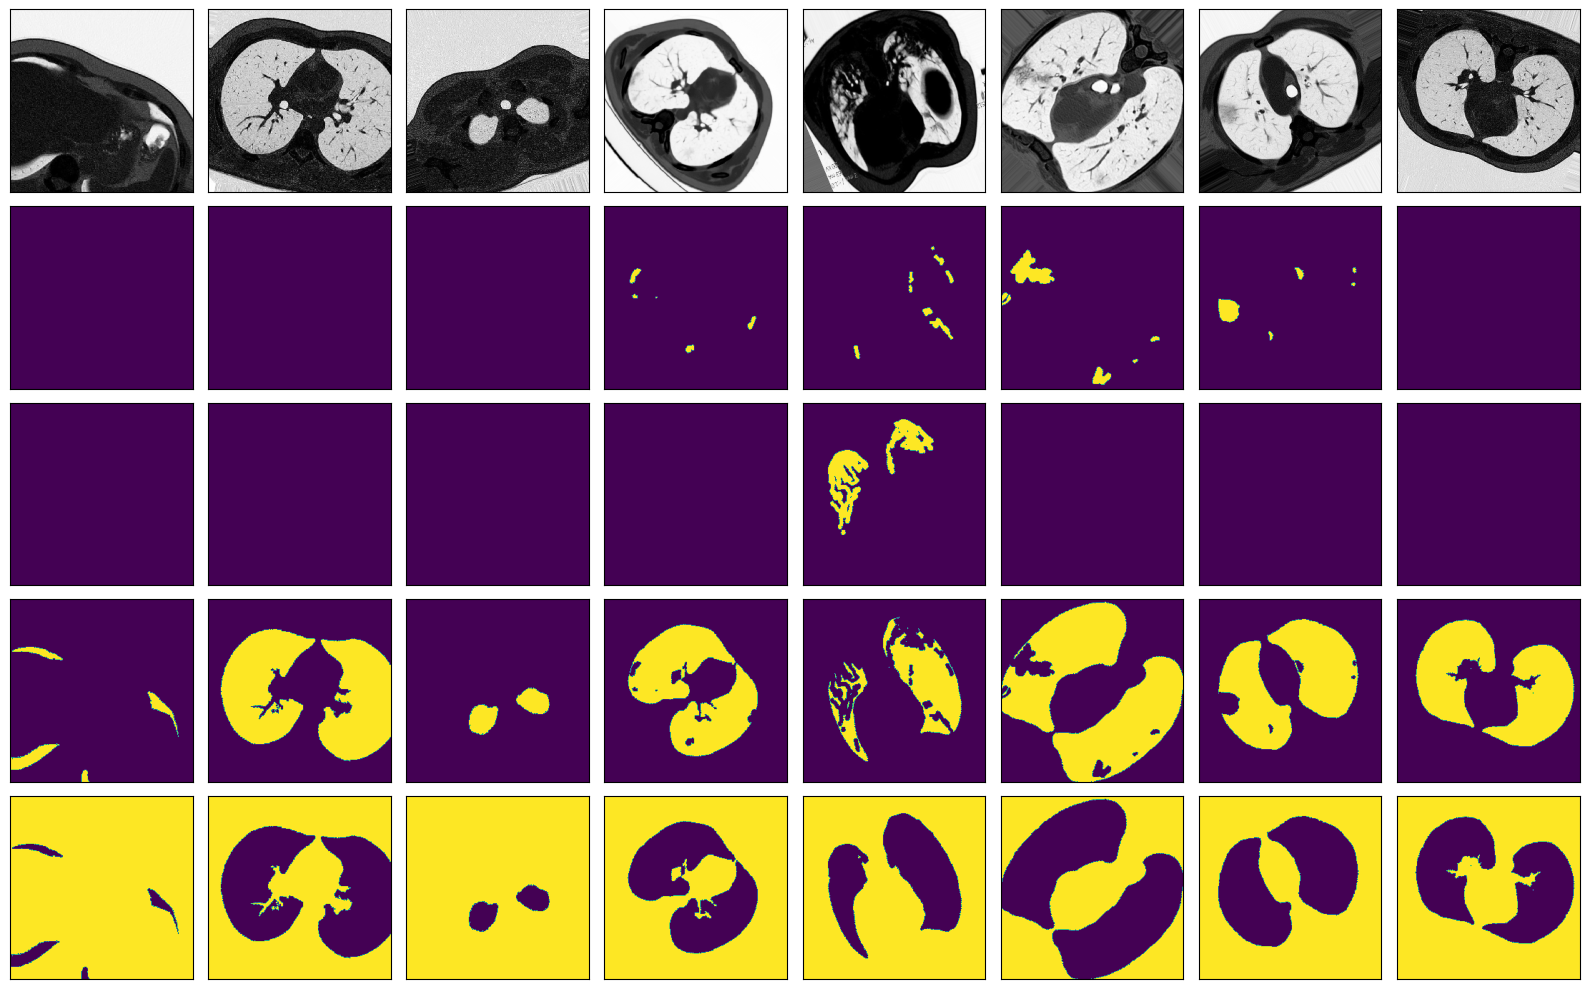

In [14]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        #print('colour',colour)
        equality = np.equal(mask, colour)
        #print('equality',equality)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

i,train_data = next(enumerate(train_dataloader))

mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1],-1).numpy(),palette)
#visualize(torch.unsqueeze(torch.squeeze(train_data[0],1),-1),mask_hot_encoded)
visualize(train_data[0].permute(0, 2, 3,1),mask_hot_encoded)


## pixel_accuracy

It computes the pixel-wise accuracy for a predicted segmentation mask by comparing it to the "ground truth" mask.

"Pixel-wise accuracy" is a metric used in image segmentation tasks, where the goal is to classify each pixel of an image into a specific category (For example: tissue_healthy, tissue_infected, air, water, etc). This metric measures the percentage of pixels in an image that have been correctly classified and match the correct label in the reference mask (ground truth).

The steps followed in the pixel_accuracy function are:

1.  The model's output is passed through a softmax activation function to convert it into probabilities for each class at each pixel location.
2.  The class with the highest probability is selected for each pixel using torch.argmax, creating a predicted segmentation mask.
3.  A comparison is made between the predicted mask and the ground truth mask (both now containing class indices), generating a binary matrix where 1 indicates correct predictions and 0 indicates incorrect ones.
4.  The total number of correct predictions is summed, and the result is divided by the total number of pixels in the mask to calculate the pixel-wise accuracy.
5.  The function returns the accuracy as a floating-point value.

In [15]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

## mIoU 
..
:3
..

Mean Intersection over Union (mIoU) is a metric used in image segmentation tasks to evaluate a model's performance. It calculates the average Intersection over Union (IoU) between the predicted and true labels for each class. **IoU** for a specific class is then calculated by dividing the number of pixels correctly predicted as that class (intersection) by the total number of pixels belonging to that class in either the prediction or the ground truth (union).

The steps followed in the function are:

1. The model's output is passed through a softmax function to obtain probabilities for each class at each pixel.
2. The class with the highest probability for each pixel is selected using torch.argmax, creating a predicted mask.
3. Both the predicted mask and the ground truth mask are flattened into one-dimensional vectors for easier comparison.
4. A list is initialized to store the IoU for each class.
5. The function loops through each class:
   - It identifies the pixels in the predicted mask that belong to the current class and the corresponding pixels in the ground truth.
   - If there are no pixels of the current class in the ground truth, np.nan is added to the IoU list for that class.
   - Otherwise, the intersection (pixels correctly predicted as that class) and the union (pixels belonging to that class in either mask) are calculated.
   - The IoU for that class is computed by dividing the intersection by the union, and the result is added to the list.
6. Finally, the function returns the average IoU across all classes, ignoring any nan values, which gives the overall mIoU score.

In [16]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## iou

It the Intersection over Union (IoU) between a predicted segmentation mask (pred) and a ground truth mask (gt). 

"IoU" is a metric that measures the overlap between the predicted and true labels for a specific class.

It is calculated as the ratio of the intersection (where both masks agree on the class) to the union (where either mask shows the class).

The steps followed in the function are:

1.  The predicted mask (pred) and ground truth mask (gt) are squeezed to remove any unnecessary dimensions, moved to the CPU (if they're on a GPU), and converted to NumPy arrays.
2.  The function converts the predicted mask into a labeled format using the ToLabel() function, which likely assigns class labels to the prediction.
3.  An aggregated matrix (agg) is created by summing the predicted and ground truth masks. Each pixel value in this matrix represents a combination of the predicted and actual classes.
4.  The number of pixels where both pred and gt are 1 (i.e., both predict the same class) is calculated as i, representing the intersection.
5.  The union (u) is calculated as the number of pixels where either pred or gt (or both) are greater than 0, representing pixels where the class is either predicted or present in the ground truth.
6.  If there are no pixels in the union (u == 0), the IoU is set to 1 (perfect match). Otherwise, the IoU is computed as the ratio i/u (intersection over union).

In [17]:
def iou(pred, gt):
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))
    u = float(np.sum(agg > 0))
    if u == 0:
        result = 1
    else:
        result = i/u
    return result

In [18]:
model = smp.Unet('efficientnet-b2',in_channels=1, encoder_weights='imagenet',classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
#decoder_attention_type ='scse'

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

### In this specific case, the selected model is a variant of the U-Net architecture using EfficientNet-B2 as the encoder.

* EfficientNet-B2 is part of the EfficientNet family.

* It is designed to achieve an optimal balance between computational efficiency and accuracy.

* It uses a technique called "compound scaling" to simultaneously adjust the depth (number of layers), width (number of filters), and resolution (input size) of the model.

* It has also proven to be very effective in image classification tasks, achieving high accuracy in visual feature extraction.

* The architecture includes high-performance convolution blocks and advanced techniques like depthwise separable convolution that optimize precision.

* The encoder in the U-Net with 5 levels of depth allows the model to capture features at different scales. Each additional level in the encoder extracts more complex and abstract features.

* The U-Net architecture includes a decoder that increases the resolution of the extracted features using upsampling operations and convolution layers. This allows for the reconstruction of the segmented image from high-level features.

**Main characteristics of EfficientNet-B2 (Encoder):**

- **Number of layers**: EfficientNet-B2 has a total of 16 convolutional layers in its encoder structure.
- **Convolution kernel size**: EfficientNet-B2 typically uses 3x3 and 5x5 kernels in its main convolutions.  
- **Stride**: The stride varies depending on the layer. In the initial layers of the encoder, the stride is often 2 to quickly reduce the image's dimensionality. In later layers, the stride may be 1 to maintain resolution during deep feature extraction.  
- **Padding**: EfficientNet-B2 uses "same" padding in most of its convolutional layers, meaning the output size remains the same as the input after applying the convolution, preserving the resolution throughout the model.  
- **Max Pooling**: EfficientNet does not explicitly use traditional max pooling operations. Instead, it relies on strided convolutions to reduce the feature resolution, improving the model's computational efficiency.

**U-Net (Decoder)**  
- **Number of layers**: The U-Net decoder has 5 levels, with convolutional layers that progressively increase the image resolution.  
- **Convolution kernel size**: In the U-Net decoder, 3x3 kernels are typically used in the convolution operations to accurately capture features during upsampling.  
- **Stride**: The stride in the decoder is usually 1 to maintain the resolution while reconstructing the segmented image.  
- **Padding**: "Same" padding is used in the decoder's convolutions to ensure that the output resolution matches the input at each layer.  
- **Max Pooling**: U-Net uses upsampling in the decoder instead of max pooling. The resolution is restored using interpolation or transposed convolutions, rather than pooling.

# Model training:

A GPU device is used for training the set, as it speeds up the process, paralelizing the computations. The training was made in Kaggle, **using the GPU P100 accelerator**.

The functions used for training are the following:

## Fit Function

This function is responsible for training and evaluating the model on a dataset over a specified number of epochs.


## Loss Function (criterion) 

The criterion argument represents the loss function used to train the model. Inside this, we use a cross-entropy funcion.

* Disclaimer: Optimizer, Learning Rate, and Scheduler The optimizer, passed as a parameter (optimizer), can be Adam or SGD, and adjusts the model's weights based on the gradients. The learning rate is controlled through the optimizer and can be dynamically adjusted with a scheduler, as seen in scheduler.step(). The function get_lr(optimizer) retrieves the current learning rate and stores it in the lrs list at each training step. In this case we use Adam.

### Number of Epochs and Minibatch Size The number of epochs (epochs)

The batch size is defined when creating the DataLoader, and defines how many times the model will train over the entire dataset.

The minibatch size is determined using train_loader and val_loader, which divide the dataset into minibatches. 

### Regularization Techniques Early stopping:

If the validation loss does not improve for 7 consecutive epochs (not_improve == 7), training is stopped to avoid overfitting. 

### Weight decay: 

this could be included in the optimizer's configuration although it's not explicitly mentioned... 

### Best model saving: 

The model is saved every time the validation loss decreases (if decrease % 5 == 0), preserving the best-performing model during training. 

### Training Loop Steps Training Phase: 

The model is put in training mode with model.train(). Each batch of images and masks passes through the model, the loss is calculated, backpropagation is performed with loss.backward(), and the optimizer updates the weights using optimizer.step(). 

The scheduler adjusts the learning rate after each step with scheduler.step(). 

### Validation Phase: 

After each epoch, the model is evaluated on the validation set using model.eval(), preventing weight updates. 

* The mIoU metrics and pixel accuracy are calculated for both the training and validation sets, along with the validation loss. Logging and Monitoring After each epoch, the training loss, validation loss, accuracy, and mIoU scores are logged to monitor progress. If the validation loss improves, the model is saved.

This process is designed to train and evaluate a segmentation model, monitoring its performance and adjusting hyperparameters throughout training.

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    #torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask =mask_tiles.to(device);
            #forward
            output = model(image)
            
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask =mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet_efficientnet_b2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

# Training:

The new epochs were found by trial and error (15 being a number were overfitting was minimum and the metrics were higher). The weight decay and learning rate was not changed from the starting notebook.

In [20]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.404 
Epoch:1/15.. Train Loss: 1.492.. Val Loss: 1.404.. Train mIoU:0.107.. Val mIoU: 0.146.. Train Acc:0.270.. Val Acc:0.283.. Time: 7.84m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.404 >> 0.634 
Epoch:2/15.. Train Loss: 0.827.. Val Loss: 0.634.. Train mIoU:0.389.. Val mIoU: 0.429.. Train Acc:0.767.. Val Acc:0.877.. Time: 8.49m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.634 >> 0.347 
Epoch:3/15.. Train Loss: 0.285.. Val Loss: 0.347.. Train mIoU:0.480.. Val mIoU: 0.437.. Train Acc:0.966.. Val Acc:0.904.. Time: 8.61m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.347 >> 0.292 
saving model...
Epoch:4/15.. Train Loss: 0.134.. Val Loss: 0.292.. Train mIoU:0.483.. Val mIoU: 0.438.. Train Acc:0.969.. Val Acc:0.908.. Time: 8.64m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.292 >> 0.246 
Epoch:5/15.. Train Loss: 0.096.. Val Loss: 0.246.. Train mIoU:0.483.. Val mIoU: 0.440.. Train Acc:0.971.. Val Acc:0.914.. Time: 8.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.246 >> 0.224 
Epoch:6/15.. Train Loss: 0.076.. Val Loss: 0.224.. Train mIoU:0.535.. Val mIoU: 0.507.. Train Acc:0.976.. Val Acc:0.925.. Time: 8.64m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.224 >> 0.220 
Epoch:7/15.. Train Loss: 0.064.. Val Loss: 0.220.. Train mIoU:0.615.. Val mIoU: 0.568.. Train Acc:0.981.. Val Acc:0.935.. Time: 8.22m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.220 >> 0.220 
Epoch:8/15.. Train Loss: 0.057.. Val Loss: 0.220.. Train mIoU:0.632.. Val mIoU: 0.559.. Train Acc:0.982.. Val Acc:0.935.. Time: 8.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.220 >> 0.205 
saving model...
Epoch:9/15.. Train Loss: 0.052.. Val Loss: 0.205.. Train mIoU:0.636.. Val mIoU: 0.572.. Train Acc:0.983.. Val Acc:0.934.. Time: 8.29m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.205 >> 0.199 
Epoch:10/15.. Train Loss: 0.049.. Val Loss: 0.199.. Train mIoU:0.642.. Val mIoU: 0.574.. Train Acc:0.983.. Val Acc:0.938.. Time: 8.19m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:11/15.. Train Loss: 0.048.. Val Loss: 0.205.. Train mIoU:0.644.. Val mIoU: 0.528.. Train Acc:0.984.. Val Acc:0.929.. Time: 8.14m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.205 >> 0.200 
Epoch:12/15.. Train Loss: 0.047.. Val Loss: 0.200.. Train mIoU:0.640.. Val mIoU: 0.565.. Train Acc:0.984.. Val Acc:0.936.. Time: 8.24m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.200 >> 0.197 
Epoch:13/15.. Train Loss: 0.046.. Val Loss: 0.197.. Train mIoU:0.644.. Val mIoU: 0.565.. Train Acc:0.984.. Val Acc:0.936.. Time: 8.64m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.197 >> 0.194 
Epoch:14/15.. Train Loss: 0.045.. Val Loss: 0.194.. Train mIoU:0.647.. Val mIoU: 0.572.. Train Acc:0.984.. Val Acc:0.938.. Time: 8.27m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.194 >> 0.193 
saving model...
Epoch:15/15.. Train Loss: 0.045.. Val Loss: 0.193.. Train mIoU:0.647.. Val mIoU: 0.570.. Train Acc:0.984.. Val Acc:0.937.. Time: 8.10m
Total time: 125.24 m


In [21]:
torch.save(model, 'Unet-efficientnet.pt')

After training the model, the plots for loss, mean iou and accuracy are made:

In [22]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

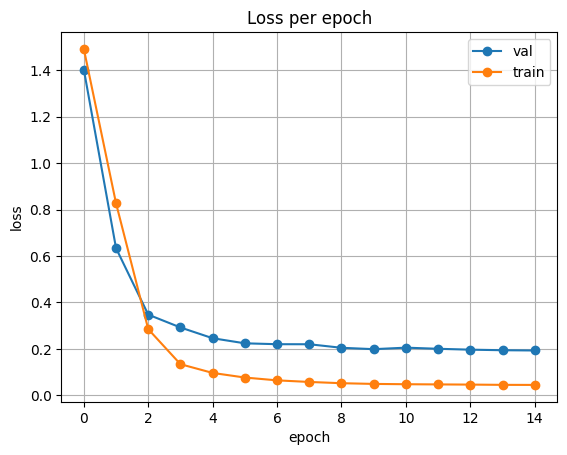

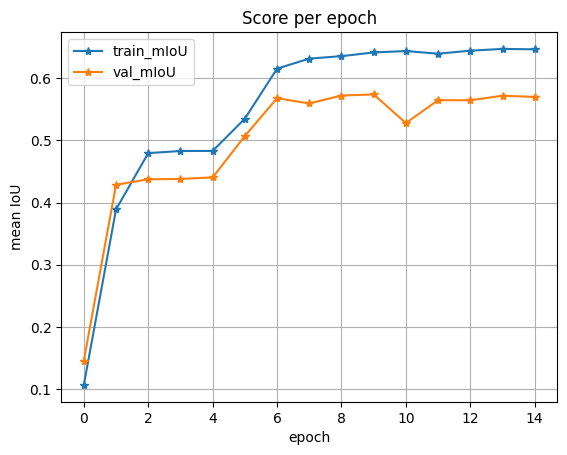

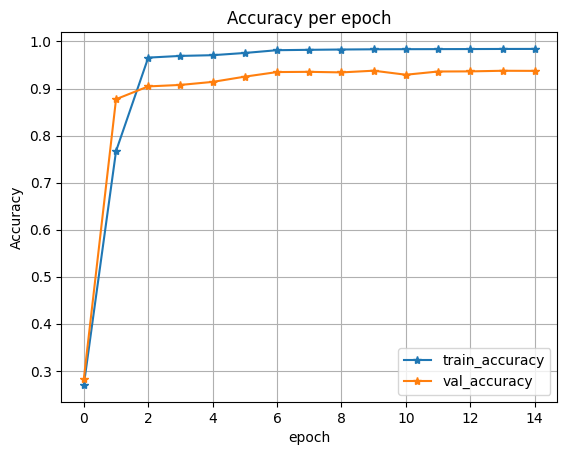

In [23]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation and metrics:

* **Loss:**

The first graph shows the behavior of the loss over epochs for both training and validation. The loss seems extremely high in the first epoch of validation and then drops almost to zero. This indicates that the model quickly adjusts to the images.

* **mIoU (Mean Intersection over Union)**:

The second graph shows the mIoU, which measures the overlap between the predicted and ground truth areas for segmentation. This metric is particularly important in image segmentation tasks because it is more robust for evaluating the overlap between the segmented and actual areas. Both training and validation sets have some variation before the 8th epoch, where both start to increase steadily.

* **Accuracy**:

The third graph displays the model’s accuracy, measuring the percentage of correctly segmented pixels. The results show a small gap between training accuracy. Although accuracy is useful, it is not ideal for segmentation tasks where the background class (non-lesion) might dominate the evaluation.

# Results:

To predict a mask for an image we need the a fucntion that sets the model to evaluation mode to stop the training.

Thos makes predictions using the model, and calculates the mIoU score to finally return the predicted mask and the score.

In [24]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    
    
    with torch.no_grad():
        
        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)
        
        output = model(image)
        a,b,c,d = output.shape
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3,1)

Next, another function is created. This one works similalry to the previous one, but instead of calculating the mIoU, it checks how many individual pixels the model predicted correclty by using the metric pixel_accuracy that was mentioned in the **Model** functions.

In [25]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

Now using mask_to_onehot function converts a colored mask (H,W,C) into one-hot encoding (H,W,K) so we can see the semantic map.

In [26]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

Then, by using the functions defined above, we fetch a batch of images and masks from the validation dataset and pass the images through the model to predict the masks.

After that, we then calculate the mIoU score to se how well the predicted mask overlaps with the actual mask, and convert the true mask to one-hot encoding.


In [27]:
image, mask = next(iter(val_dataloader))
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

To then, FINALLY visualize our results:

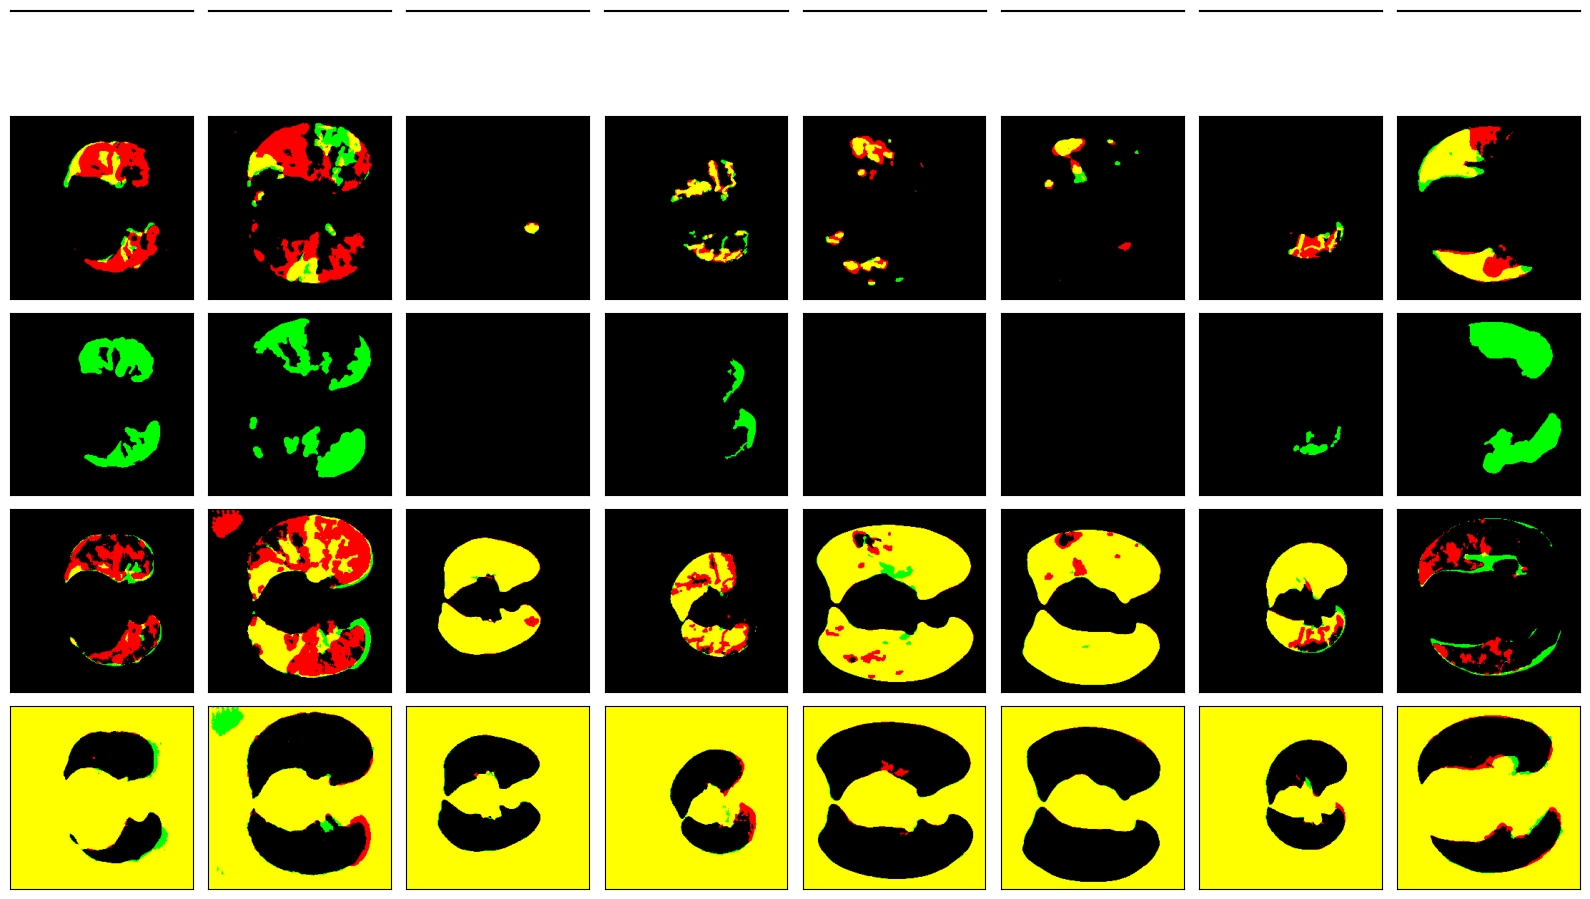

In [28]:
visualize(image.cpu(), semantic_map, pred_batch=output.cpu())


# yellow is TP, red is FP, green is FN

* **Yellow:** Pixels are where both model prediction and true masking are enabled for a specific class. This means that the model has been correct in its prediction for those pixels.

* **Red:** are the pixels where the model prediction is positive (the model predicts the class), but the true mask is negative (does not predict the class). This means that the model has incorrectly identified these pixels as belonging to the class when in fact they are not.

* **Green:** Pixels are where the true mask is positive (that is, the pixels actually belong to the class), but the model prediction is negative. Although miselading, green does not mean they are correctly predicted, but rather that the model has not correctly identified these pixels that should have been classified as part of the class.

There is a considerable amount of correct values with respect to the Ground Truth, but there are still several red pixels, meaning that those values are being identified in a class when they really are not.

Knowing that there are still some values being identified in a class when they're actually not in one, we create a function to calculate the mIoU score for every image in the validation/test set. 

This loops over the dataset and predicts the mask for each image and calculates their score, so it can store this score in a list which when shown, provides an insight on how the model performs accross all images in the test set.

In [29]:
def miou_score(model, test_set):
    score_iou = []
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [30]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.5699206810482893]

We clean up the training data with stuff we have already defined in the **Split train / val** function

In [31]:
del train_images
del train_masks

## Test preds:

And to test, we create a function to normalize and predict the mask for a single image in the test set by using a softmax function to normalize the output probabilities. 

We then reshape the predicted mask to match the expected shape for processing.


In [32]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.eval()
    
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        output = model(torch.unsqueeze(image,1))
        output = nn.Softmax(dim=1)(output)
    return output.permute(0, 2, 3,1)

After reshaping the predicted mask to match the expected shape, we process a batch of images from the test set and predict masks for each image in the batch, converting them from tensors to arrays. 

--> The predicted masks are thresholded to 0.5 and the final masks are displayed along the input images <--

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


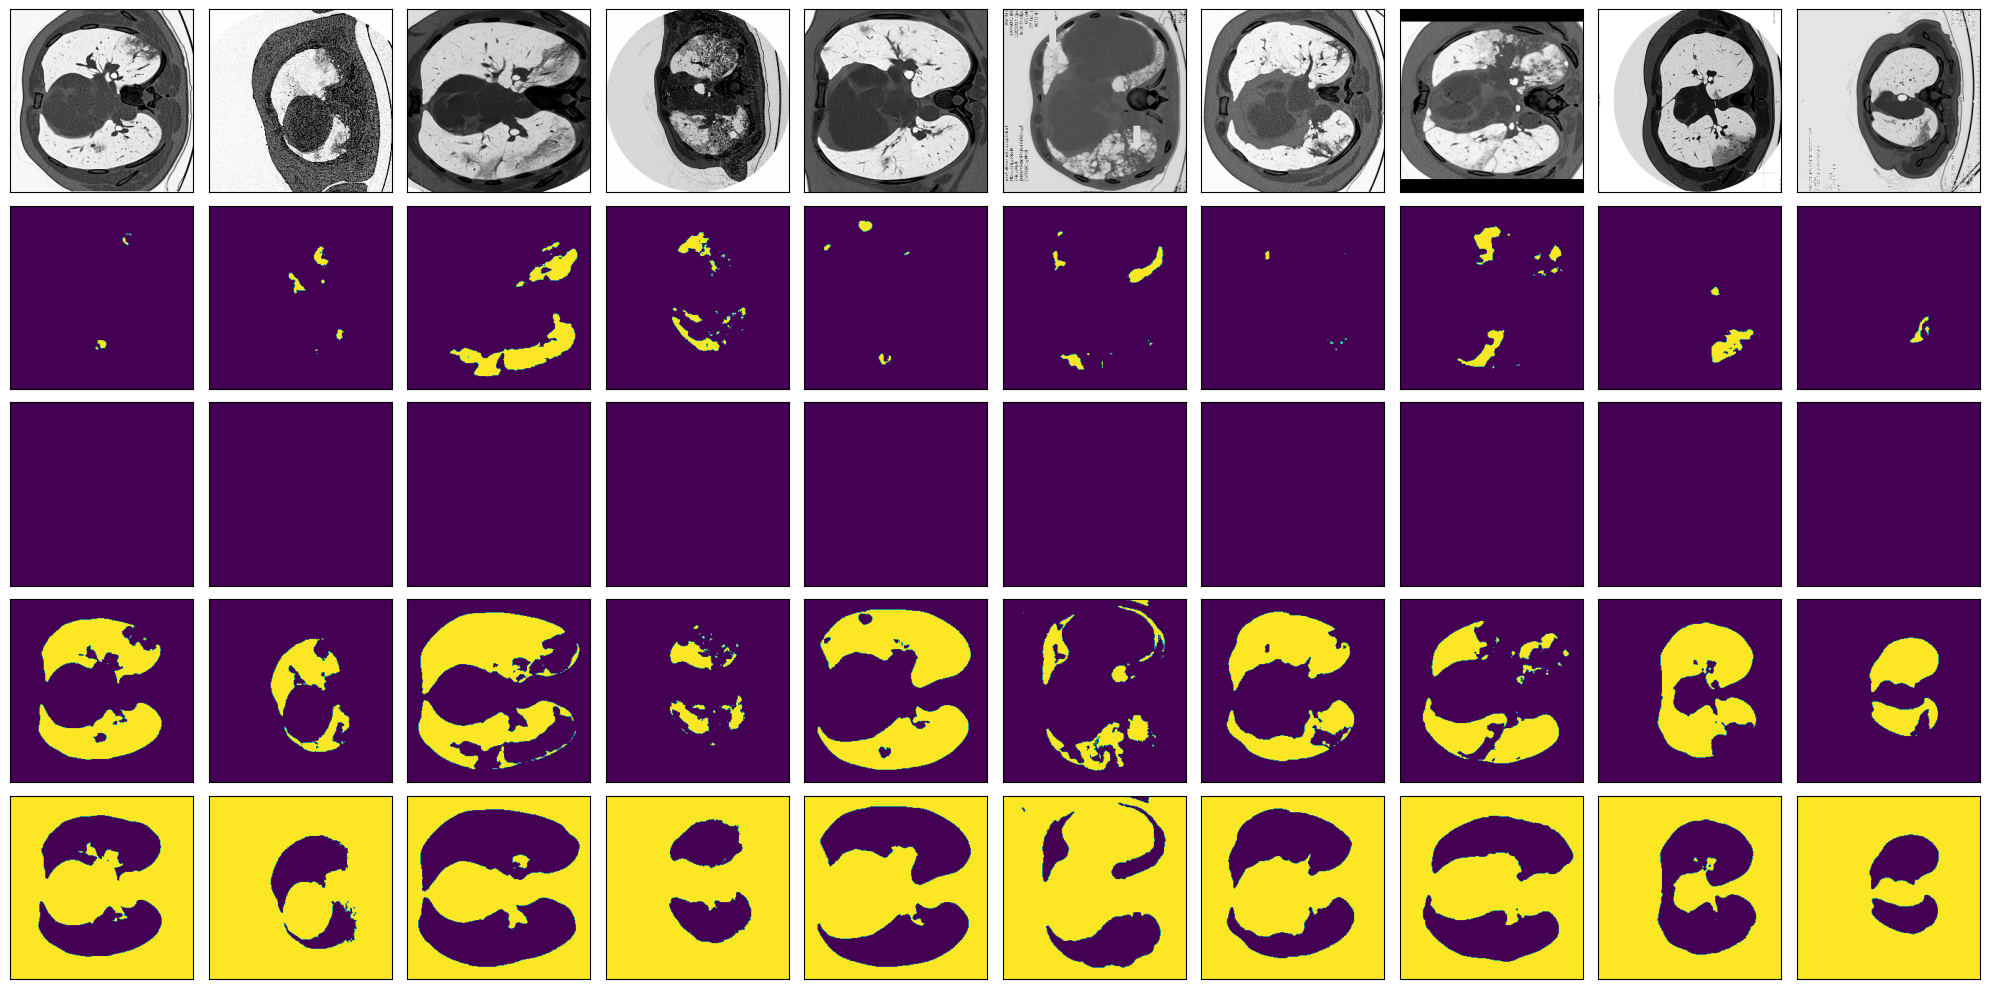

In [33]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
output = np.zeros((10,256,256,4))
for i in range(10):   
    output[i] = test_predict(model, image_batch[i]).cpu().numpy()
print(output.shape)
test_masks_prediction = output > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

## Resize prediction to original size:

We resize the predicted masks using scipy, this way, we enlarge the predicted masks to match the original image resolution (size, kinda).

In [34]:
import scipy
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

Then we flatten the masks predicted to a one-dmensional array, and transform the data to a DataFrame and save it as a CSV File.

The file content will have the index and the predicted mask values for each pixel:

In [35]:
import pandas as pd

pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())), 
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')

# Conclusions:

The results show that the model is generally effective in segmenting infected regions of the lungs, successfully identifying both small and large areas relevant for diagnosis. However, errors were also observed. False positives, where healthy regions were misclassified as infected, suggest a tendency toward over-prediction and a possible overfitting. These false negatives were less frequent but indicate challenges in detecting subtle or small infections. 

Despite these limitations, many predictions matched the ground truth closely, particularly in the lower image rows, highlighting the model’s ability to capture key features of lung infection. 

Future improvements could include refining the loss function to better balance small region detection and applying post-processing to reduce false positives.

## Refrences:

Radiopedia source (images): https://radiopaedia.org/articles/covid-19-4?lang=us

Medseg source (images): https://sirm.org/en/

Lr tunning : https://arxiv.org/abs/1506.01186

Unet: Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation (arXiv:1505.04597). arXiv.
https://doi.org/10.48550/arXiv.1505.04597